In [3]:
%matplotlib inline
# %matplotlib notebook
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import datetime
import glob
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from scipy.stats import ttest_ind, sem, gaussian_kde
import collections
import matplotlib.ticker as plticker

## Define monthly baseflow
To be used in comparing ratios of streamflows

In [2]:
# monthly baseflows. Actually, I just need chiang saen as an example of bounday condition inflow.
baseflow=pd.DataFrame()
csvals=[1150,930,830,910,1300,2460,4720,6480,5510,3840,2510,1590]
baseflow['Chiang Saen']=csvals
bf_monsoon=[np.mean(csvals[3:5]), np.mean(csvals[5:9]), np.mean(csvals[9:11]), \
            (csvals[11]+np.sum(csvals[:3]))/4]
baseflow['Luang Prabang']=[1690,1280,1060,1110,1570,3110,6400,9920,8990,5750,3790,2400]
# baseflow['Vientiane']=[1760,1370,1170,1190,1720,3410,6920,11000,10800,6800,4230,2560]
# baseflow['Nakhon Phanom']=[2380,1860,1560,1530,2410,6610,12800,19100,18500,10200,5410,3340]
# baseflow['Mukdahan']=[2370,1880,1600,1560,2430,7090,13600,20600,19800,10900,5710,3410]
# baseflow['Pakse']=[2800,2170,1840,1800,2920,8810,16600,26200,26300,15400,7780,4190]
baseflow['Kratie']=[3620,2730,2290,2220,3640,11200,22200,35500,36700,22000,10900,5710]

print(baseflow)
bf_monsoon

    Chiang Saen  Luang Prabang  Kratie
0          1150           1690    3620
1           930           1280    2730
2           830           1060    2290
3           910           1110    2220
4          1300           1570    3640
5          2460           3110   11200
6          4720           6400   22200
7          6480           9920   35500
8          5510           8990   36700
9          3840           5750   22000
10         2510           3790   10900
11         1590           2400    5710


[1105.0, 4792.5, 3175.0, 1125.0]

## Read and prep data
Read frxst_pts_out files, combines them into two dataframes,  
then adds columns describing the station name and their order  
in the lower Mekong River

In [3]:
# directory='C:/Users/likkhian/SkyDrive/Thesis/wrfhydro_output/'
directory='../wrfhydro_output/'
df1=pd.read_csv(directory+'frxst_full_s2000.csv',dayfirst=True,header=0)
df1['datetime']=pd.to_datetime(df1['datetime'])
df2=pd.read_csv(directory+'frxst_full_eas0c.csv',dayfirst=True,header=0)
df2['datetime']=pd.to_datetime(df2['datetime'])


'''Everything below is used to create the df that is saved in frxst_full_*.csv'''
# files_2000=['frxst_pts_out_2000_01','frxst_pts_out_2000_02','frxst_pts_out_2000_03']
# files_eas0c=['frxst_pts_out_eas0c_01','frxst_pts_out_eas0c_02','frxst_pts_out_eas0c_03']

def readtable(fileloc):
    df=pd.read_table(fileloc,delimiter=",",header=None)
    df.columns=['s in simulation','datetime','stationID','lon','lat', \
    'discharge m3s','discharge ft3s','depth']
    df['datetime']=pd.to_datetime(df['datetime'])
    return df
def makefilename(var):
    return directory+var+'.txt'
def combine_files(file_list):
    df=readtable(makefilename(file_list[0]))
    df2 = pd.concat([df,readtable(makefilename(file_list[1]))])
    df3 = pd.concat([df2,readtable(makefilename(file_list[2]))])
    return df3
def label_station(row):
    '''
    This function reorders stations in the order they are encountered
    starting from the mouth of the lower Mekong River, and travelling upstream
    '''
#     if ((abs(row['lon']-105.24291)<0.01) & (abs(row['lat']-10.80413)<0.01)):
    if (row['stationID'] == 0):
        return 'Tan Chau'
#     if ((abs(row['lon']-105.28458)<0.01) & (abs(row['lat']-11.26228)<0.01)):
    if (row['stationID'] == 1):
        return 'Neak Loung'
#     if ((abs(row['lon']-104.95117)<0.01) & (abs(row['lat']-11.56459)<0.01)):
    if (row['stationID'] == 2):
        return 'Phnom Penh'
#     if ((abs(row['lon']-104.80947)<0.01) & (abs(row['lat']-11.80947)<0.01)):
    if (row['stationID'] == 3):
        return 'Prek Kdam'
#     if ((abs(row['lon']-105.47630)<0.01) & (abs(row['lat']-11.98890)<0.01)):
    if (row['stationID'] == 4):
        return 'Kampong Cham'
#     if ((abs(row['lon']-106.01810)<0.01) & (abs(row['lat']-12.46953)<0.01)):
    if (row['stationID'] == 5):
        return 'Kratie'
#     if ((abs(row['lon']-105.94308)<0.01) & (abs(row['lat']-13.52535)<0.01)):
    if (row['stationID'] == 6):
        return 'Stung Treng'
#     if ((abs(row['lon']-105.81805)<0.01) & (abs(row['lat']-15.10829)<0.01)):
    if (row['stationID'] == 7):
        return 'Pakse'
#     if ((abs(row['lon']-105.56799)<0.01) & (abs(row['lat']-15.32545)<0.01)):
    if (row['stationID'] == 8):
        return 'Khong Chiam'
#     if ((abs(row['lon']-104.75113)<0.01) & (abs(row['lat']-16.52774)<0.01)):
    if (row['stationID'] == 9):
        return 'Mukdahan'
#     if ((abs(row['lon']-104.80113)<0.01) & (abs(row['lat']-17.38086)<0.01)):
    if (row['stationID'] == 10):
        return 'Thakhek'
#     if ((abs(row['lon']-102.71729)<0.01) & (abs(row['lat']-17.87338)<0.01)):
    if (row['stationID'] == 11):
        return 'Nongkhai' #12
#     if ((abs(row['lon']-101.65870)<0.01) & (abs(row['lat']-17.88925)<0.01)):
    if (row['stationID'] == 12):
        return 'Chiang Khan' #14
#     if ((abs(row['lon']-102.61726)<0.01) & (abs(row['lat']-17.92097)<0.01)):
    if (row['stationID'] == 13):
        return 'Vientiane' #13
#     if ((abs(row['lon']-103.65919)<0.01) & (abs(row['lat']-18.37246)<0.01)):
    if (row['stationID'] == 14):
        return 'Paksane' #11
#     if ((abs(row['lon']-102.05046)<0.01) & (abs(row['lat']-19.86875)<0.01)):
    if (row['stationID'] == 15):
        return 'Luang Prabang'
#     if ((abs(row['lon']-102.56725)<0.01) & (abs(row['lat']-20.52587)<0.01)):
    if (row['stationID'] == 16):
        return 'ChiangSaen'

def station_order(row):
    '''
    This function reorders stations in the order they are encountered
    starting from the mouth of the lower Mekong River, and travelling upstream
    '''
    if (row['stationID'] == 0):
        return 0
    if (row['stationID'] == 1):
        return 1
    if (row['stationID'] == 2):
        return 2
    if (row['stationID'] == 3):
        return 3
    if (row['stationID'] == 4):
        return 4
    if (row['stationID'] == 5):
        return 5
    if (row['stationID'] == 6):
        return 6
    if (row['stationID'] == 7):
        return 7
    if (row['stationID'] == 8):
        return 8
    if (row['stationID'] == 9):
        return 9
    if (row['stationID'] == 10):
        return 10
    if (row['stationID'] == 11):
        return 12 #12
    if (row['stationID'] == 12):
        return 14 #14
    if (row['stationID'] == 13):
        return 13 #13
    if (row['stationID'] == 14):
        return 11 #11
    if (row['stationID'] == 15):
        return 15
    if (row['stationID'] == 16):
        return 16

/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# #save to csv
# df1.to_csv(directory+'frxst_full_s2000.csv')
# df2.to_csv(directory+'frxst_full_eas0c.csv')

In [5]:
%%time
# df1=combine_files(files_2000)
# df2=combine_files(files_eas0c)
# print('adding station name and order...')
# # print(zip(*df1.iloc[:10,:].apply(label_station,axis=1)))
# df1['station name']=df1.apply(label_station,axis=1)
# print('next')
# df1['order']=df1.apply(station_order,axis=1)
# print('next')
# df2['station name']=df2.apply(label_station,axis=1)
# print('next')
# df2['order']=df2.apply(station_order,axis=1)
# print(df1.describe())
# print(df1[['stationID','lon','lat','station name','order']].iloc[:17])
# print(df1.columns.values)
base=datetime.datetime(2090,1,1)
time=np.array([base + datetime.timedelta(hours=i) for i in range(len(df1.loc[df1['stationID']==3]))])
print(time)
#read the calibration file
calibration=readtable(makefilename('frxst_pts_out_calibrate'))
calibration['station name']=calibration.apply(label_station,axis=1)
calibration['order']=calibration.apply(station_order,axis=1)
timed=np.array([base + datetime.timedelta(days=i) for i in range(len(calibration.loc[calibration['stationID']==3]))])
print(calibration.describe())

[datetime.datetime(2090, 1, 1, 0, 0) datetime.datetime(2090, 1, 1, 1, 0)
 datetime.datetime(2090, 1, 1, 2, 0) ...
 datetime.datetime(2102, 1, 1, 21, 0) datetime.datetime(2102, 1, 1, 22, 0)
 datetime.datetime(2102, 1, 1, 23, 0)]
       s in simulation     stationID           lon           lat  \
count     1.241000e+04  12410.000000  12410.000000  12410.000000   
mean      3.157920e+07      8.000000    104.349062     15.306898   
std       1.820803e+07      4.899177      1.428546      3.148147   
min       8.640000e+04      0.000000    101.658700     10.804130   
25%       1.581120e+07      4.000000    102.717290     11.988900   
50%       3.157920e+07      8.000000    104.809470     15.325450   
75%       4.734720e+07     12.000000    105.476300     17.889250   
max       6.307200e+07     16.000000    106.018100     20.525870   

       discharge m3s  discharge ft3s         depth         order  
count   12410.000000    1.241000e+04  12410.000000  12410.000000  
mean     3477.984116    1

## Plots
### Calculating monthly flowrates for each station

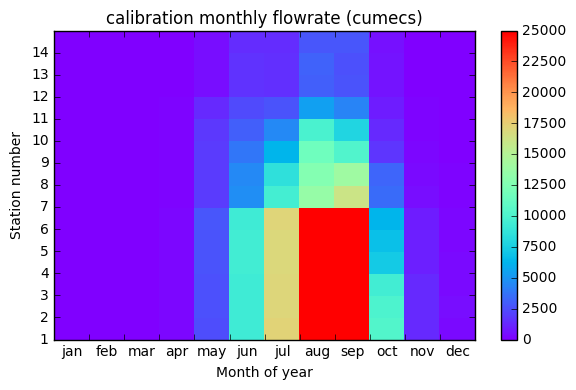

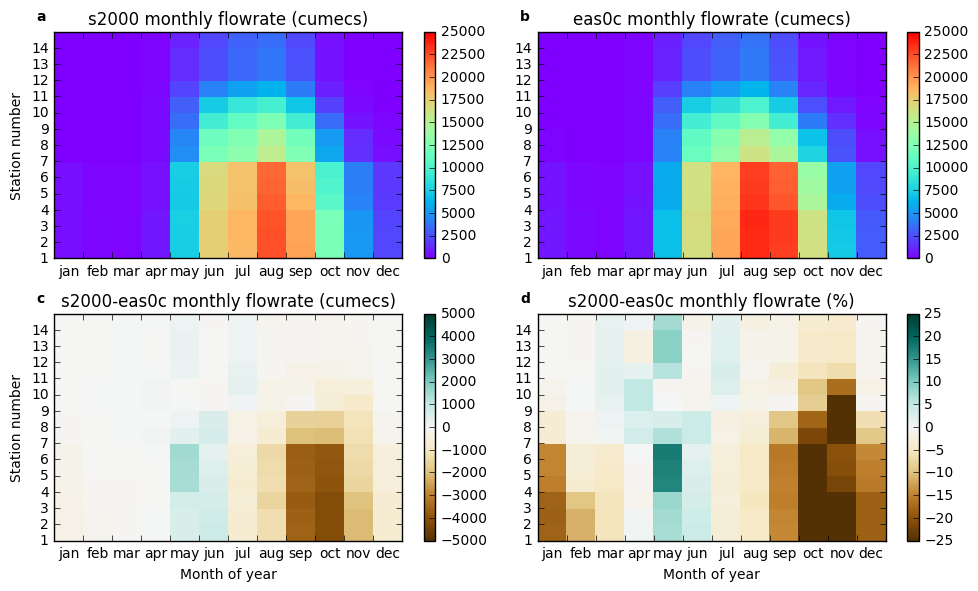

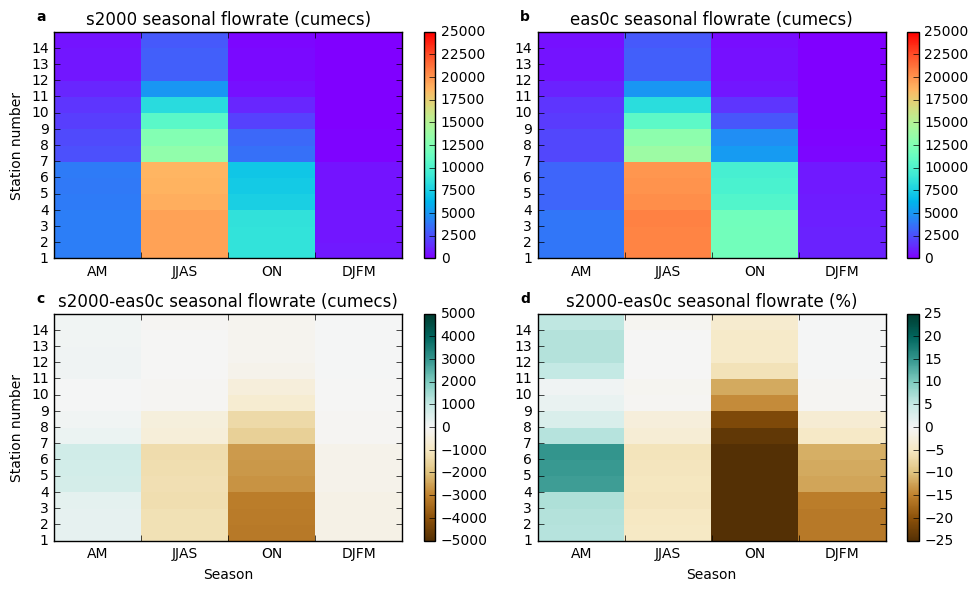

In [6]:
#calculate monthly rates
from matplotlib import ticker
stations=df1['stationID'].unique()
def mergetime(data,ii): #function to extract hourly timeseries from a single station
    station=data.loc[data['order']==ii][['datetime','discharge m3s']].copy() #extract by order instead of station number
    return station

def daily(data,stn): #to calculate daily data
    station_hourly=mergetime(data,stn)
    station_daily = station_hourly.resample('D',on='datetime').mean()
    return station_daily
    
def yearly(data,stn): # function to calculate mean for each year
    station_data=mergetime(data,stn)
    station_data=np.mean(station_data.reshape([-1,24]),axis=1)
    daycut=0
    out=[]
    for i in range(1,13):
        if (i+2%4):
            out.append(np.mean(station_data[daycut:daycut+366]))
            daycut+=366
        else:
            out.append(np.mean(station_data[daycut:daycut+365]))
            daycut+=365
    return np.array(out)

def group_mth(data,stn):
    station_hourly=mergetime(data,stn)
    grouped=station_hourly.groupby(station_hourly['datetime'].dt.month).mean()
    return grouped['discharge m3s']

def group_monsoon(data,stn):
    mapping={1:'DJFM',2:'DJFM',3:'DJFM',4:'AM',5:'AM',6:'JJAS',7:'JJAS',8:'JJAS',\
             9:'JJAS',10:'ON',11:'ON',12:'DJFM'}
    station_hourly=mergetime(data,stn)
    grouped=station_hourly.groupby(station_hourly['datetime'].dt.month.map(mapping)).mean()
    return grouped['discharge m3s'][['AM','JJAS','ON','DJFM']]
    
# idd=9
# test1=group_mth(df1,idd)
# print(test1)
# print(df1.sample(1))
# test2=yearly(df2,idd)
# print(sem(test1))
# plt.plot(test1)
# plt.plot(test2)
test1=np.empty([14,12]) #s2000
test2=np.empty([14,12]) #eas0c
test3=np.empty([14,12]) #calibration
test4=np.empty([14,4]) #seasonal s2000
test5=np.empty([14,4]) #seasonal eas0c
inx=0
for idd in range(0,17):
    if (idd != 3) & (idd <15):
#         print(inx)
        test1[inx,:]=group_mth(df1,idd)
        test2[inx,:]=group_mth(df2,idd)
        test3[inx,:]=group_mth(calibration.loc[calibration['datetime']>'2015-01-01'],idd)
        test4[inx,:]=group_monsoon(df1,idd)
        test5[inx,:]=group_monsoon(df2,idd)
        inx+=1
def maketick(monsoon=False):
    plt.yticks(np.arange(0,14),['1','2','3','4','5','6','7','8','9','10','11','12','13','14'])
    ax=plt.gca()
    if(monsoon==True):
        month_name=['AM','JJAS','ON','DJFM']
    else:
        month_name=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # Customize minor tick labels
    if(monsoon==True):
        ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5,1.5,2.5,3.5]))
    else:
        ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(month_name))
    ax.tick_params(axis='x',which='minor',length=0)
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

test1a=np.empty(np.shape(test1)) # for relative difference, include baseflow.
for i in range(0,14):
    test1a[i,:]=test1[i,:]+baseflow['Chiang Saen'].T
test4b=np.empty(np.shape(test4)) #to include baseflow for seasonal
for i in range(0,14):
    test4b[i,:]=test4[i,:]+bf_monsoon

plt.rcParams["figure.figsize"] = 6,4
plt.figure(1)    
plt.pcolormesh((test3),cmap='rainbow',vmin=0,vmax=25000)
maketick()
plt.colorbar()
plt.title('calibration monthly flowrate (cumecs)')
plt.ylabel('Station number')
plt.xlabel('Month of year')
plt.tight_layout()

plt.rcParams["figure.figsize"] = 10,6
plt.figure(2)
plt.subplot(2,2,1)
plt.pcolormesh((test1),cmap='rainbow',vmin=0,vmax=25000)
maketick()
plt.colorbar()
plt.title('s2000 monthly flowrate (cumecs)')
plt.ylabel('Station number')
ax=plt.gca()
ax.text(-0.05, 1.05, 'a', transform=ax.transAxes,size=10, weight='bold')
plt.subplot(2,2,2)
plt.pcolormesh((test2),cmap='rainbow',vmin=0,vmax=25000)
maketick()
plt.colorbar()
plt.title('eas0c monthly flowrate (cumecs)')
ax=plt.gca()
ax.text(-0.05, 1.05, 'b', transform=ax.transAxes,size=10, weight='bold')
plt.subplot(2,2,3)
plt.pcolormesh(test1-test2,vmin=-5000,vmax=5000,cmap='BrBG') #5000 for streamflow cumecs
maketick()
plt.colorbar()
plt.title('s2000-eas0c monthly flowrate (cumecs)')
plt.ylabel('Station number')
plt.xlabel('Month of year')
ax=plt.gca()
ax.text(-0.05, 1.05, 'c', transform=ax.transAxes,size=10, weight='bold')
plt.subplot(2,2,4)
plt.pcolormesh((test1-test2)/test1a*100,vmin=-25,vmax=25,cmap='BrBG')
maketick()
plt.colorbar()
plt.title('s2000-eas0c monthly flowrate (%)')
plt.xlabel('Month of year')
ax=plt.gca()
ax.text(-0.05, 1.05, 'd', transform=ax.transAxes,size=10, weight='bold')
plt.tight_layout()

plt.rcParams["figure.figsize"] = 10,6
plt.figure(3)
plt.subplot(2,2,1)
plt.pcolormesh(test4,cmap='rainbow',vmin=0,vmax=25000)
maketick(monsoon=True)
plt.colorbar()
plt.title('s2000 seasonal flowrate (cumecs)')
plt.ylabel('Station number')
ax=plt.gca()
ax.text(-0.05, 1.05, 'a', transform=ax.transAxes,size=10, weight='bold')
plt.subplot(2,2,2)
plt.pcolormesh(test5,cmap='rainbow',vmin=0,vmax=25000)
maketick(monsoon=True)
plt.colorbar()
plt.title('eas0c seasonal flowrate (cumecs)')
ax=plt.gca()
ax.text(-0.05, 1.05, 'b', transform=ax.transAxes,size=10, weight='bold')
plt.subplot(2,2,3)
plt.pcolormesh(test4-test5,vmin=-5000,vmax=5000,cmap='BrBG') #5000 for streamflow cumecs
maketick(monsoon=True)
plt.colorbar()
plt.title('s2000-eas0c seasonal flowrate (cumecs)')
plt.ylabel('Station number')
plt.xlabel('Season')
ax=plt.gca()
ax.text(-0.05, 1.05, 'c', transform=ax.transAxes,size=10, weight='bold')
plt.subplot(2,2,4)
plt.pcolormesh((test4-test5)/test4b*100,vmin=-25,vmax=25,cmap='BrBG') #no baseflow added!
maketick(monsoon=True)
plt.colorbar()
plt.title('s2000-eas0c seasonal flowrate (%)')
plt.xlabel('Season')
ax=plt.gca()
ax.text(-0.05, 1.05, 'd', transform=ax.transAxes,size=10, weight='bold')
plt.tight_layout()
plt.show()

In [7]:
(test4-test5)/test4b*100

array([[ 6.18255788e+00, -4.84551915e+00, -2.61419275e+01,
        -1.56607711e+01],
       [ 6.42346227e+00, -4.91257042e+00, -2.60468800e+01,
        -1.57327670e+01],
       [ 6.66544173e+00, -5.30045252e+00, -2.57805709e+01,
        -1.54228345e+01],
       [ 1.42807965e+01, -5.20358870e+00, -2.53623638e+01,
        -1.22780206e+01],
       [ 1.46713358e+01, -5.38777261e+00, -2.53619009e+01,
        -1.18092387e+01],
       [ 1.51873711e+01, -5.58231611e+00, -2.55721770e+01,
        -1.13673619e+01],
       [ 6.07690294e+00, -3.21858073e+00, -2.36710942e+01,
        -4.53667261e+00],
       [ 3.07998268e+00, -2.68683767e+00, -2.11895024e+01,
        -3.33857966e+00],
       [ 1.17204472e+00, -3.57877172e-01, -1.40882414e+01,
        -2.97249009e-01],
       [ 7.54173166e-01, -4.40656793e-01, -1.18536647e+01,
        -3.89893670e-01],
       [ 5.17257577e+00, -1.79164644e-01, -5.76040086e+00,
         1.97709393e-02],
       [ 6.32456733e+00, -8.97653704e-02, -4.30092196e+00,
      

[[1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910. 1300. 2460. 4720. 6480. 5510. 3840. 2510. 1590.]
 [1150.  930.  830.  910.

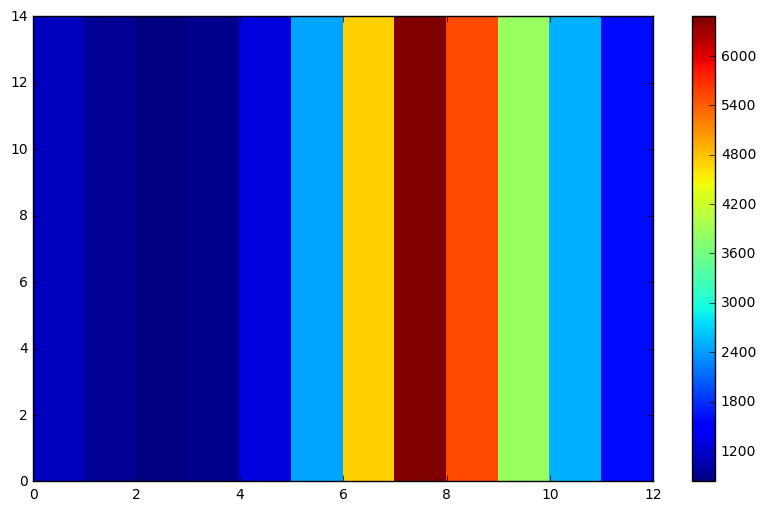

In [8]:
np.shape(test1)
test1a=np.empty(np.shape(test1))
for i in range(0,14):
    test1a[i,:]=test1[i,:]+baseflow['Chiang Saen'].T
print(test1a-test1)
plt.pcolormesh((test1a-test1))
plt.colorbar()
plt.show()

## Plot overall means
### Print mean for each station

0 Tan Chau,8926.65
1 Neak Loung,8924.90
2 Phnom Penh,8899.66
3 Prek Kdam,372.89
4 Kampong Cham,8514.17
5 Kratie,8365.95
6 Stung Treng,8304.45
7 Pakse,5556.28
8 Khong Chiam,5246.74
9 Mukdahan,4271.17
10 Thakhek,3269.46
11 Paksane,1233.56
12 Nongkhai,1112.52
13 Vientiane,1221.83
14 Chiang Khan,1971.36
15 Luang Prabang,708.64
16 ChiangSaen,1.88


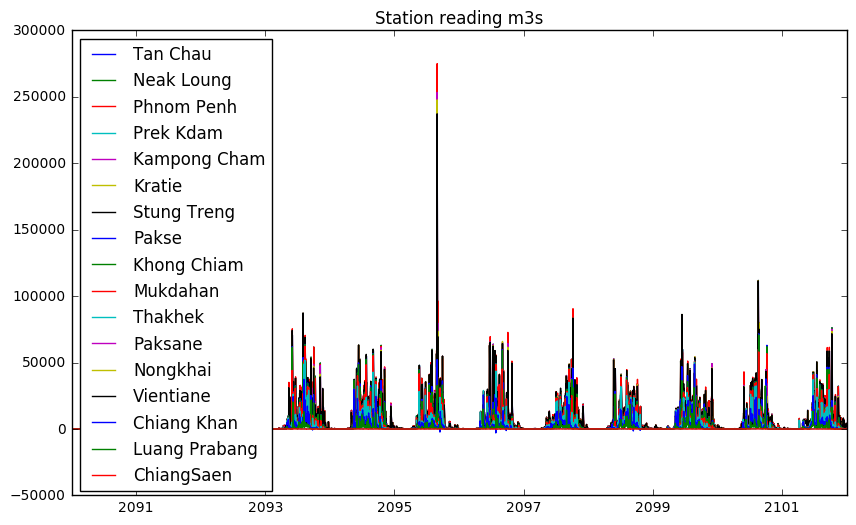

0 Tan Chau,9886.89
1 Neak Loung,9884.90
2 Phnom Penh,9876.76
3 Prek Kdam,506.57
4 Kampong Cham,9335.78
5 Kratie,9175.47
6 Stung Treng,9113.76
7 Pakse,6003.31
8 Khong Chiam,5630.39
9 Mukdahan,4408.05
10 Thakhek,3373.65
11 Paksane,1241.37
12 Nongkhai,1130.50
13 Vientiane,1229.76
14 Chiang Khan,1993.02
15 Luang Prabang,749.94
16 ChiangSaen,2.93


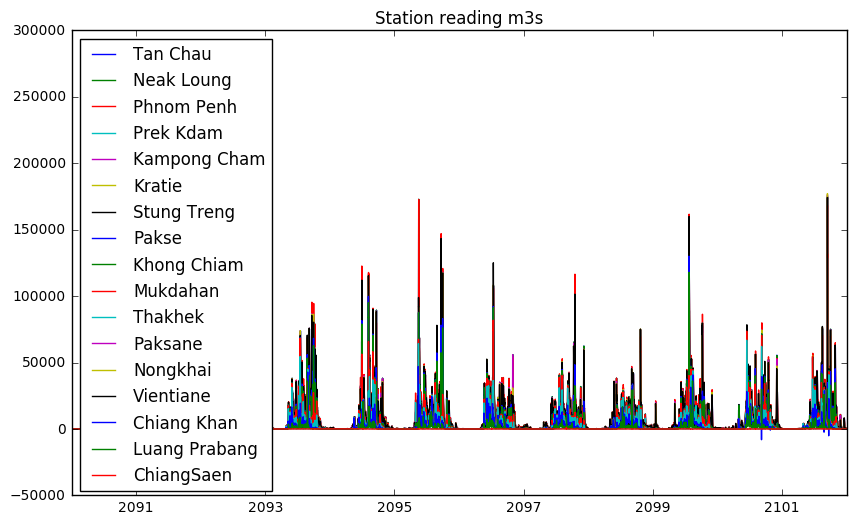

In [9]:
stationNames=('Tan Chau','Neak Loung','Phnom Penh','Prek Kdam','Kampong Cham', \
'Kratie','Stung Treng','Pakse','Khong Chiam','Mukdahan','Thakhek','Paksane', \
'Nongkhai','Vientiane','Chiang Khan','Luang Prabang','ChiangSaen') #correct order

def plt_stn(df):
    stations=df['stationID'].unique()
    for ii in (stations):
        plt.plot(time,df.loc[df['stationID']==ii]['discharge m3s'],label=stationNames[ii])
        print(ii,'{},{:.2f}'.format(stationNames[ii],np.mean(df.loc[df['stationID']==ii]['discharge m3s'])))
    plt.title('Station reading m3s')
    plt.legend(loc='upper left')
    plt.show()
# print(stations)
plt_stn(df1)
plt_stn(df2)

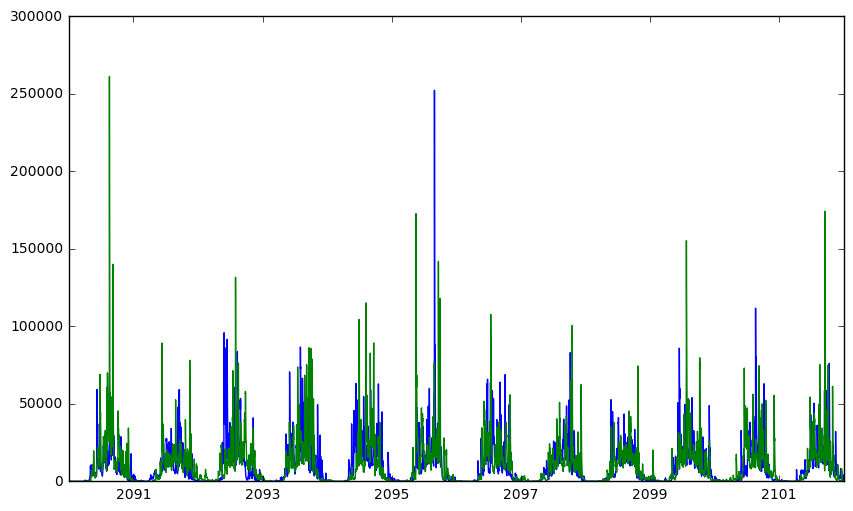

In [10]:
idd=0
plt.plot(time,df1.loc[df1['stationID']==idd]['discharge m3s'],label=stationNames[idd])
plt.plot(time,df2.loc[df2['stationID']==idd]['discharge m3s'],label=stationNames[idd])
plt.show()

#### calculate mean difference

In [11]:
from scipy.stats import sem
def get_mean(df):
    stdd=[] #standard deviation
    mean=[]
    lats=[]
    lons=[]
    stations=df['stationID'].unique()
    print(stations)
    for ii in (stations):
        if (ii != 3) & (ii <15) :
            mean.append(np.mean(df.loc[df['order']==ii]['discharge m3s']))
            stdd.append(sem(df.loc[df['order']==ii]['discharge m3s']))
            lons.append(df.loc[df['order']==ii]['lon'].iloc[0])
            lats.append(df.loc[df['order']==ii]['lat'].iloc[0])
    return mean,stdd,lons,lats
mean_2000,std_2000,lons,lats=np.array(get_mean(df1))
mean_eas0c,std_eas0c,lons,lats=np.array(get_mean(df2))
diff=mean_2000-mean_eas0c
ratio=diff/mean_2000
std=((std_2000**2)+std_eas0c**2)**0.5
std_ratio=std/mean_2000*100
print(diff,ratio)
print(std)
print(std_ratio)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[-960.24339159 -960.00729247 -977.10361872 -821.61586007 -809.51778795
 -809.31460779 -447.03505278 -383.65220798 -136.8864456  -104.19125161
  -21.66224266   -7.80400252   -7.93584772  -17.97821793] [-0.10757043 -0.1075651  -0.10979113 -0.09649987 -0.09676336 -0.09745559
 -0.08045583 -0.07312203 -0.03204895 -0.03186807 -0.01098847 -0.00632638
 -0.00649507 -0.0161599 ]
[58.83298757 58.8517671  59.32930835 56.85142233 56.26024192 55.92027543
 39.99561924 38.02196095 31.39163651 24.65176209 15.49994518 10.33079017
 10.28279632  9.77842063]
[0.65907144 0.65941125 0.66664698 0.66772748 0.67249045 0.67337763
 0.71982739 0.72467794 0.73496615 0.75400194 0.78625616 0.83747464
 0.84159214 0.87894331]


[-960.24339159 -960.00729247 -977.10361872 -821.61586007 -809.51778795
 -809.31460779 -447.03505278 -383.65220798 -136.8864456  -104.19125161
   -7.80400252  -17.97821793   -7.93584772  -21.66224266]  
   [-0.10757043 -0.1075651  -0.10979113 -0.09649987 -0.09676336 -0.09745559
 -0.08045583 -0.07312203 -0.03204895 -0.03186807 -0.00632638 -0.0161599
 -0.00649507 -0.01098847]  
[ 58.83298757  58.8517671   59.32930835  56.85142233  56.26024192
  55.92027543  39.99561924  38.02196095  31.39163651  24.65176209
  10.33079017   9.77842063  10.28279632  15.49994518]  
[ 0.65907144  0.65941125  0.66664698  0.66772748  0.67249045  0.67337763
  0.71982739  0.72467794  0.73496615  0.75400194  0.83747464  0.87894331
  0.84159214  0.78625616]

[1506, 1450, 1387, 1289, 1174, 1044, 839, 804, 596, 491, 320, 167, 137, 0]


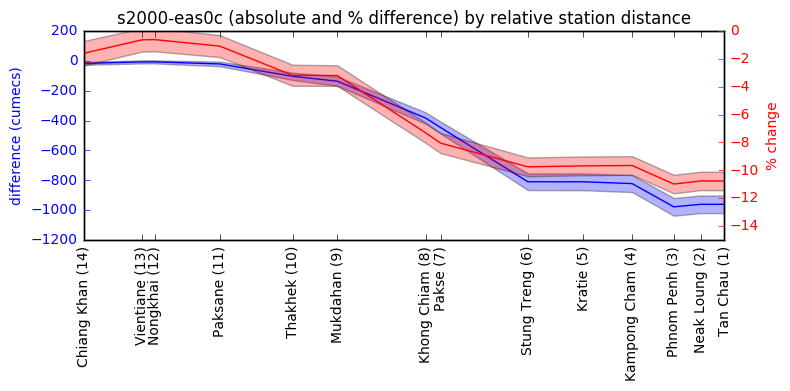

In [12]:
# station_dist={'ChiangSaen':0,'Luang Prabang':104,'Paksane':415,'Vientiane':552,'Chiang Khan':582,\
#              'Nongkhai':735,'Thakhek':906,'Mukdahan':1011,'Khong Chiam':1219,'Pakse':1254, \
#              'Stung Treng':1459,'Kratie':1589,'Kampong Cham':1704,'Prek Kdam':1827,'Phnom Penh':1802, \
#              'Neak Loung':1865,'Tan Chau':1921}
station_dist2=collections.OrderedDict([('Chiang Khan (14)',0),('Vientiane (13)',137),('Nongkhai (12)',167),\
             ('Paksane (11)',320),('Thakhek (10)',491),('Mukdahan (9)',596),('Khong Chiam (8)',804),('Pakse (7)',839), \
             ('Stung Treng (6)',1044),('Kratie (5)',1174),('Kampong Cham (4)',1289),('Phnom Penh (3)',1387), \
             ('Neak Loung (2)',1450),('Tan Chau (1)',1506)])
distances=[]
tickname=[]
for i,ii in enumerate(station_dist2):
    distances.append(station_dist2[ii])
    tickname.append(ii)
distances.sort(reverse=True)
tickname=tickname[::-1]

print(distances)

plt.rcParams["figure.figsize"] = 8,4
ax1=plt.subplot()
ax1.plot(distances,diff,'b')
ax1.fill_between(distances,diff-std,diff+std,alpha=0.3,facecolor='blue')
# ax1.set_xlabel('Grid distance from first station (grid points)')
ax1.set_ylabel('difference (cumecs)', color='b')
ax1.tick_params('y', colors='b')
plt.xticks(distances,tickname,rotation='90')
ax2=plt.twinx()
ax2.plot(distances,ratio*100,'r')
ax2.fill_between(distances,ratio*100-std_ratio,ratio*100+std_ratio,alpha=0.3,facecolor='red')
ax2.set_ylabel('% change',color='r')
ax2.set_ylim([-15,0])
ax2.tick_params('y',colors='r')
plt.title('s2000-eas0c (absolute and % difference) by relative station distance')
plt.tight_layout()
plt.show()

Plot locations of stations and the overall differences in mean flow rate underlaid with DEM data

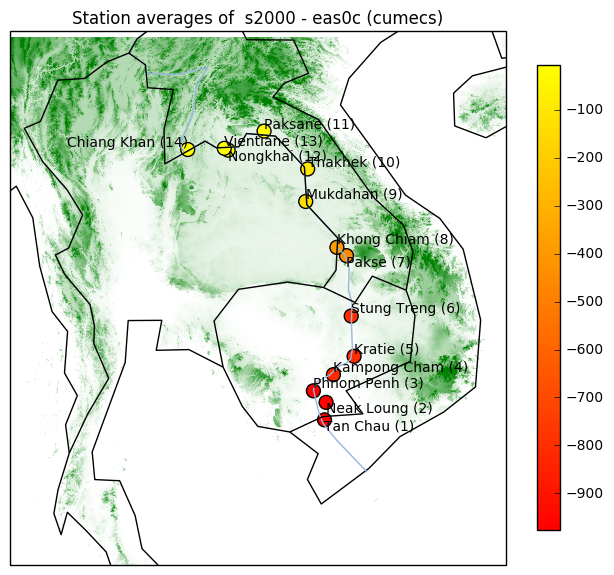

In [13]:
#import DEM data
fulldom=xr.open_dataset('../HydrologySection/wrfhydroInputs/Fulldom_hiresD.nc')

from adjustText.adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['figure.figsize'] = 8, 10
stationNames2=('Tan Chau (1)','Neak Loung (2)','Phnom Penh (3)','Kampong Cham (4)', \
'Kratie (5)','Stung Treng (6)','Pakse (7)','Khong Chiam (8)','Mukdahan (9)','Thakhek (10)','Paksane (11)', \
'Nongkhai (12)','Vientiane (13)','Chiang Khan (14)')

ax = plt.axes(projection=ccrs.PlateCarree())
mycmap = LinearSegmentedColormap.from_list('mycmap',['white','green'])
ax.pcolormesh(fulldom.LONGITUDE,fulldom.LATITUDE,fulldom.TOPOGRAPHY,cmap=mycmap,vmin=0,vmax=1500)
ax.scatter(lons,lats,c=diff,marker='o',s=100,cmap='autumn')
ax.coastlines()
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.BORDERS)
# ax.stock_img()
ax.set_extent([97, 110, 7, 21])

# for i, txt in enumerate(stationNames2):
#     ax.annotate(txt, (lons[i],lats[i]),fontsize='8')
# make the station names not overlap
texts=[]
for x, y, s in zip(lons, lats, stationNames2):
    texts.append(plt.text(x, y, s))
adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1,1), expand_text=(1,1))
# PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
for PCM in ax.get_children(): 
    if type(PCM) == matplotlib.collections.PathCollection: break
plt.colorbar(PCM, ax=ax, shrink=0.6)
ax.set_title('Station averages of  s2000 - eas0c (cumecs)')
plt.show()

In [14]:
stations=df1['stationID'].unique()
names=df1['station name'].unique()
for ii in stations:
    print(ii,names[ii],ttest_ind(df1.loc[df1['stationID']==ii]['discharge m3s'],df2.loc[df2['stationID']==ii]['discharge m3s']))

0 Tan Chau Ttest_indResult(statistic=-16.32151334297076, pvalue=7.554177138223416e-60)
1 Neak Loung Ttest_indResult(statistic=-16.31229340766855, pvalue=8.78382090487566e-60)
2 Phnom Penh Ttest_indResult(statistic=-16.469155731934578, pvalue=6.673873852579946e-61)
3 Prek Kdam Ttest_indResult(statistic=-17.704584589513463, pvalue=4.346629329831748e-70)
4 Kampong Cham Ttest_indResult(statistic=-14.45198424897722, pvalue=2.5664353587245923e-47)
5 Kratie Ttest_indResult(statistic=-14.388807447167968, pvalue=6.404420108463889e-47)
6 Stung Treng Ttest_indResult(statistic=-14.472650601353646, pvalue=1.901260726732519e-47)
7 Pakse Ttest_indResult(statistic=-11.177100425196203, pvalue=5.37901964002156e-29)
8 Khong Chiam Ttest_indResult(statistic=-10.090279364848536, pvalue=6.176630303326588e-24)
9 Mukdahan Ttest_indResult(statistic=-4.360602403764308, pvalue=1.2976635517128765e-05)
10 Thakhek Ttest_indResult(statistic=-4.22652349223631, pvalue=2.374293976481579e-05)
11 Nongkhai Ttest_indResult(

## Seasonal analysis
Seasons separated into monsoon and intermonsoon seasons instead of 4 quarters.  Follow months scheme below!  

AM, JJAS, ON, DJFM  
i1, sum, i2, win

In [15]:
#

# Mass balance
Looking at qstrmvolrt, and maybe comparing it to ppt output?  
Data is prepared from raw [DATE].RTOUT.domain2 netcdf files
extracting the variable QSTRMVOLRT which is the cumulative water entering each river grid.  
We then use another python script to find the sum of water entering the river systems and output daily cumulative values as sum\_qstrmvolrt_*.txt files. <br>
The reason we do this is because the qstrmvolrt.txt direct from the model have restart values in them, and they do not add up to the correct number of timesteps.

In [16]:
import matplotlib.dates as mdate
files_qstrm_2000=['sum_qstrmvolrt_2000_01','sum_qstrmvolrt_2000_02','sum_qstrmvolrt_2000_03']
files_qstrm_eas0c=['sum_qstrmvolrt_eas0c_01','sum_qstrmvolrt_eas0c_02','sum_qstrmvolrt_eas0c_03']
qstrm_2000_1=np.loadtxt(makefilename(files_qstrm_2000[0]))
qstrm_2000_2=np.loadtxt(makefilename(files_qstrm_2000[1]))
qstrm_2000_3=np.loadtxt(makefilename(files_qstrm_2000[2]))
qstrm_eas0c_1=np.loadtxt(makefilename(files_qstrm_eas0c[0]))
qstrm_eas0c_2=np.loadtxt(makefilename(files_qstrm_eas0c[1]))
qstrm_eas0c_3=np.loadtxt(makefilename(files_qstrm_eas0c[2]))

qstrm_time=np.array([base + datetime.timedelta(hours=i) for i in range(0,len(qstrm_2000_1))])

qstrm_time=np.arange('2000-01-01','2003-12-31',dtype='datetime64[D]')
qstrm_time=qstrm_time.astype(datetime.datetime)
print(qstrm_time)

#calculate overall mass balance
print('{:.4e}'.format(np.mean(df1[df1['stationID']==0]['discharge m3s'])*4*365.25*24*60*60))

[datetime.date(2000, 1, 1) datetime.date(2000, 1, 2)
 datetime.date(2000, 1, 3) ... datetime.date(2003, 12, 28)
 datetime.date(2003, 12, 29) datetime.date(2003, 12, 30)]
1.1268e+12


First, look at the raw data

(1462,)


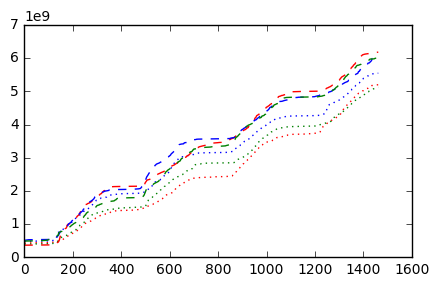

In [17]:
plt.rcParams['figure.figsize'] = 5, 3
print(np.shape(qstrm_2000_1))
plt.plot(qstrm_2000_1,'r:')
plt.plot(qstrm_2000_2,'b:')
plt.plot(qstrm_2000_3,'g:')
plt.plot(qstrm_eas0c_1,'r--')
plt.plot(qstrm_eas0c_2,'b--')
plt.plot(qstrm_eas0c_3,'g--')
plt.show()

Plot a running mean, and the deaccumulated data

In [18]:
def run_mean(qstrm):
    '''
    Calculating the running mean is equivalent to 
    running a convolution on a 1D array with filter of all 1s
    since you are calculating the mean of a window with some weight.
    '''
    N=30 #choose filter size in days
    return np.convolve(qstrm,np.ones(N)/N,mode='valid')

def deaccum(qstrm):
    return qstrm[1:]-qstrm[:-1]

def extract_vals(df1):
# Just to extract the discharge data into single array with no time info
    vals=daily(df1,0)
    discharge=np.array(vals['discharge m3s'].data)
    return discharge[~np.isnan(discharge)]

(1433,) (1462,)


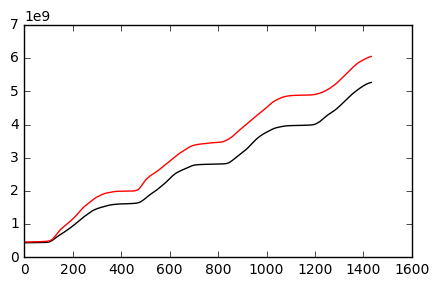

In [19]:
s1_1=run_mean(qstrm_2000_1)
print(np.shape(s1_1),np.shape(qstrm_2000_1))
s1_2=run_mean(qstrm_2000_2)
s1_3=run_mean(qstrm_2000_3)
s1_avg=(s1_1+s1_2+s1_3)/3
s2_1=run_mean(qstrm_eas0c_1)
s2_2=run_mean(qstrm_eas0c_2)
s2_3=run_mean(qstrm_eas0c_3)
s2_avg=(s2_1+s2_2+s2_3)/3

plt.figure(1)
plt.plot(s1_avg,'k')
plt.plot(s2_avg,'r')

(1461,) (4383,)


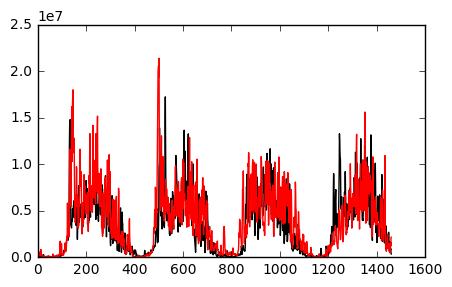

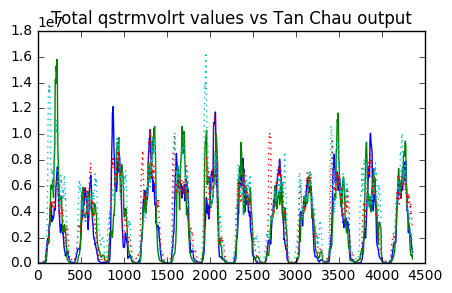

(4354,)
(4354,)


In [20]:
s1_1_run=deaccum(qstrm_2000_1)
s1_2_run=deaccum(qstrm_2000_2)
s1_3_run=deaccum(qstrm_2000_3)
s1_avg_run=(s1_1_run+s1_2_run+s1_3_run)/3
s2_1_run=deaccum(qstrm_eas0c_1)
s2_2_run=deaccum(qstrm_eas0c_2)
s2_3_run=deaccum(qstrm_eas0c_3)
s2_avg_run=(s2_1_run+s2_2_run+s2_3_run)/3
s1=np.append(s1_1_run,[s1_2_run,s1_3_run])
s2=np.append(s2_1_run,[s2_2_run,s2_3_run])
print(np.shape(s2_1_run),np.shape(s2))

plt.figure(1)
plt.plot(s1_avg_run,'k')
plt.plot(s2_avg_run,'r')

plt.figure(2)
idd=0
fact=300#60*60*24#60*24
plt.plot(run_mean(extract_vals(df1)*fact),label=stationNames[idd])
plt.plot(run_mean(extract_vals(df2)*fact),label=stationNames[idd])
plt.plot(run_mean(s1),':',label=stationNames[idd])
plt.plot(run_mean(s2),':',label=stationNames[idd])
plt.title('Total qstrmvolrt values vs Tan Chau output')


plt.show()
print(np.shape(run_mean(s1)))
print(np.shape(run_mean(extract_vals(df2)*fact)))

### Checking waterbalance from accumulated vars

In [21]:
ldasout_s101=xr.open_dataset(directory+'waterbalance_s101/2054123100.LDASOUT_DOMAIN2')
ldasout_s102=xr.open_dataset(directory+'waterbalance_s102/2073123100.LDASOUT_DOMAIN2')
ldasout_s103=xr.open_dataset(directory+'waterbalance_s103/2094123100.LDASOUT_DOMAIN2')
ldasout_s201=xr.open_dataset(directory+'waterbalance_s201/2054123100.LDASOUT_DOMAIN2')
ldasout_s202=xr.open_dataset(directory+'waterbalance_s202/2073123100.LDASOUT_DOMAIN2')
ldasout_s203=xr.open_dataset(directory+'waterbalance_s203/2094123100.LDASOUT_DOMAIN2')
ldasout_all=[ldasout_s101,ldasout_s102,ldasout_s103,ldasout_s201,ldasout_s202,ldasout_s203]

## waterbalance from calculate_stats.R from rwrfhydro

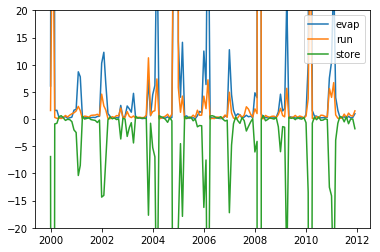

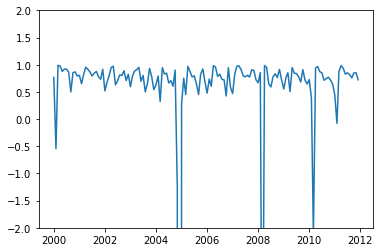

In [18]:
bal_s1_list=['hydro_balance_hydro_2000_01.csv','hydro_balance_hydro_2000_02.csv','hydro_balance_hydro_2000_03.csv']
bal_s2_list=['hydro_balance_hydro_eas0c_01.csv','hydro_balance_hydro_eas0c_02.csv','hydro_balance_hydro_eas0c_03.csv']

def combine_bal(file_list):
    df=pd.read_csv('../wrfhydro_output/'+file_list[0])
    df2 = pd.concat([df,pd.read_csv('../wrfhydro_output/'+file_list[1])])
    df3 = pd.concat([df2,pd.read_csv('../wrfhydro_output/'+file_list[2])])
    df3['dates']=pd.date_range(start='2000-01-01',periods=len(df3),freq='MS')
    df3.set_index('dates',inplace=True)
    return df3
    

bal_s1=combine_bal(bal_s1_list)
bal_s2=combine_bal(bal_s2_list)
bal_s1_mth=bal_s1.groupby(by=bal_s1.index.month).mean()
bal_s2_mth=bal_s2.groupby(by=bal_s2.index.month).mean()

plt.figure(1)
plt.plot(bal_s1['EVAP_FRAC'],label='evap')
plt.plot(bal_s1['RUN_FRAC'],label='run')
plt.plot(bal_s1['STOR_FRAC'],label='store')
plt.ylim([-20,20])
plt.legend()

plt.figure(2)
plt.plot(bal_s1['EVAP_FRAC']+bal_s1['RUN_FRAC']+bal_s1['STOR_FRAC'])
plt.ylim([-2,2])
plt.show()

In [24]:
bal_s1['total_frac']=bal_s1['EVAP_FRAC']+bal_s1['RUN_FRAC']+bal_s1['STOR_FRAC']
bal_s1.loc[bal_s1['total_frac']<-1]
# print(bal_s1.loc['2004-11-01'])
# print(bal_s1.loc['2002-11-01'])

,Unnamed: 0,ERROR,EVAP_FRAC,HYD_DELSFCHEAD,HYD_GWOUT,HYD_QBDRY,HYD_QSTRMVOL,LSM_DELCANWAT,LSM_DELSOILM,LSM_DELSWE,...,LSM_ETRAN,LSM_PRCP,LSM_SFCRNOFF,LSM_UGDRNOFF,RUN_FRAC,STOR_FRAC,WB_DELGWSTOR,WB_GWOUT,WB_SFCRNOFF,total_frac
dates,,,,,,,,,,,,,,,,,,,,,
2004-11-01,10,0.149207,42.683148,0.0,NaN,0.0,0.0,0.0,-6.470100,0.0,...,0.050966,0.065880,2.285588e-02,3.574806,54.262352,-98.210328,0.0,3.574806,0.0,-1.264829
2004-12-01,11,0.061806,2965.376492,0.0,NaN,0.0,0.0,0.0,-2.438394,0.0,...,0.046647,0.000491,7.447282e-04,0.919938,1872.132634,-4962.288935,0.0,0.919938,0.0,-124.779809
2008-03-01,2,0.002025,1536.143856,0.0,NaN,0.0,0.0,0.0,-0.519954,0.0,...,0.086060,0.000281,3.170458e-07,0.087197,310.773132,-1853.132902,0.0,0.087197,0.0,-6.215914
2010-03-01,26,0.014426,129.221122,0.0,NaN,0.0,0.0,0.0,-0.764910,0.0,...,0.056522,0.004588,1.050905e-04,0.162196,35.351623,-166.716981,0.0,0.162196,0.0,-2.144236


In [104]:
print(bal)

,ERROR,EVAP_FRAC,HYD_DELSFCHEAD,HYD_GWOUT,HYD_QBDRY,HYD_QSTRMVOL,LSM_DELCANWAT,LSM_DELSOILM,LSM_DELSWE,LSM_ECAN,LSM_EDIR,LSM_ETRAN,LSM_PRCP,LSM_SFCRNOFF,LSM_UGDRNOFF,RUN_FRAC,STOR_FRAC,WB_DELGWSTOR,WB_GWOUT,WB_SFCRNOFF
0,0.298782,0.089073,-0.040166,None,0.0,0.241857,0.0,0.107207,0.0,0.063226,0.025266,0.000217,0.995908,3.348361,0.299519,0.543601,0.067316,0.0,0.299519,0.241857
1,0.298782,0.089073,-0.040166,None,0.0,0.241857,0.0,0.107207,0.0,0.063226,0.025266,0.000217,0.995908,3.348361,0.299519,0.543601,0.067316,0.0,0.299519,0.241857
2,0.298782,0.089073,-0.040166,NaN,0.0,0.241857,0.0,0.107207,0.0,0.063226,0.025266,0.000217,0.995908,3.348361,0.299519,0.543601,0.067316,0.0,0.299519,0.241857


In [30]:
def report_strength(dataset,variable,res):
    mm_to_m=1e-3
    grid_area=res*res
    valid_grid=np.sum(dataset[variable]>0).data
    var_sum=np.sum(dataset[variable].data[dataset[variable].data>0.1]) #ppt sum in mm
#     print('{}: valid grid={:}, sum={:.4e}m^3'.format(variable,valid_grid,var_sum*mm_to_m*valid_grid*grid_area))
    print('{:.4e}'.format(var_sum))

variables=['ACCPRCP','ACCECAN','ACCETRAN','ACCEDIR','SFCRNOFF','UGDRNOFF']
for ldasout in ldasout_all:
    print('new run')
    for variable in variables:
        report_strength(ldasout,variable,9000)

new run
2.1429e+08
1.5138e+07
1.5686e+06
4.6388e+07
2.2313e+09
9.4455e+07
new run
2.1690e+08
1.4865e+07
1.6142e+06
4.5388e+07
2.0724e+09
9.4602e+07
new run
2.1295e+08
1.5139e+07
1.5879e+06
4.5667e+07
2.5822e+09
9.4098e+07
new run
2.2981e+08
1.5116e+07
1.6367e+06
4.5354e+07
3.3751e+09
9.9545e+07
new run
2.3558e+08
1.5822e+07
1.4401e+06
4.6779e+07
3.1164e+09
1.0489e+08
new run
2.3090e+08
1.5591e+07
1.4369e+06
4.7624e+07
3.4491e+09
1.0068e+08


In [31]:
rtout_s101=xr.open_dataset(directory+'waterbalance_s101/205412310000.RTOUT_DOMAIN2')
rtout_s102=xr.open_dataset(directory+'waterbalance_s102/207312310000.RTOUT_DOMAIN2')
rtout_s103=xr.open_dataset(directory+'waterbalance_s103/209412310000.RTOUT_DOMAIN2')
rtout_s201=xr.open_dataset(directory+'waterbalance_s201/205412310000.RTOUT_DOMAIN2')
rtout_s202=xr.open_dataset(directory+'waterbalance_s202/207312310000.RTOUT_DOMAIN2')
rtout_s203=xr.open_dataset(directory+'waterbalance_s203/209412310000.RTOUT_DOMAIN2')
rtout_all=[rtout_s101,rtout_s102,rtout_s103,rtout_s201,rtout_s202,rtout_s203]

variables=['QSTRMVOLRT','SFCHEADSUBRT','QBDRYRT']
for rtout in rtout_all:
    print('new run')
    for variable in variables:
        report_strength(rtout,variable,450)

new run
5.1976e+09
6.0855e+06
0.0000e+00
new run
5.5470e+09
4.8420e+06
0.0000e+00
new run
5.1203e+09
8.4324e+06
0.0000e+00
new run
6.1802e+09
9.6551e+06
0.0000e+00
new run
6.0281e+09
1.0646e+07
0.0000e+00
new run
6.0019e+09
1.1415e+07
0.0000e+00


In [41]:
wrfout=xr.open_dataset('../../../Desktop/wrfout_d02_0054-12-31_00:00:00')
totes=(np.nansum(wrfout.RAINC.data[wrfout.RAINC.data>0])+np.nansum(wrfout.RAINNC.data[wrfout.RAINNC.data>0]))/1000*9000*9000
print('{:.4e}'.format(totes))

report_strength(wrfout,'RAINC',9000)
report_strength(wrfout,'RAINNC',9000)

4.2744e+13
4.1899e+08
1.0871e+08


/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/xarray/conventions.py:377: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)


In [34]:

print('{:.4e}'.format(qstrm_2000_1[-1]))
print('{:.4e}'.format(qstrm_2000_1[-2]))
print('{:.4e}'.format(qstrm_2000_1[-3]))

5.1979e+09
5.1976e+09
5.1974e+09


## Creating Mekong Mask

In [9]:
fulldom=xr.open_dataset('../wrfhydro_output/Fulldom_hiresD.nc')
channels=fulldom.CHANNELGRID
channels.data

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ..., 
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]])

## Reading timeseries of accum vars

In [38]:
ferlin = pd.read_csv('../wrfhydro_output/checkwater_calibrate.csv',names=['accprcp','accecan','accetran','accedir','sfcrnoff','ugdrunoff'])
print(ferlin.describe())
ferlin.head()

            accprcp       accecan       accetran       accedir      sfcrnoff  \
count  7.300000e+02  7.300000e+02     730.000000  7.300000e+02  7.300000e+02   
mean   3.421948e+07  2.699111e+06  391574.130251  8.779617e+06  1.786311e+08   
std    2.370926e+07  1.807330e+06  204825.811290  5.744779e+06  1.412553e+08   
min    1.919094e+01  0.000000e+00       0.078984  3.151208e+01  1.202634e+00   
25%    1.308820e+07  1.075281e+06  240743.711250  3.788923e+06  3.403893e+07   
50%    3.547728e+07  2.826300e+06  370126.812500  9.135950e+06  1.842431e+08   
75%    4.978510e+07  3.936842e+06  587531.328000  1.347532e+07  2.652037e+08   
max    7.583234e+07  5.761546e+06  707882.562000  1.890454e+07  4.521804e+08   

          ugdrunoff  
count  7.300000e+02  
mean   1.352195e+07  
std    9.846402e+06  
min    4.348148e+02  
25%    3.384667e+06  
50%    1.507401e+07  
75%    1.896621e+07  
max    3.149292e+07  


,accprcp,accecan,accetran,accedir,sfcrnoff,ugdrunoff
0,19.190935,0.000000,0.078984,31.512075,1.202634,434.814819
1,1747.839230,128.124084,871.121704,15174.708000,377174.031000,12447.369100
2,3875.075930,357.351135,1892.934690,30543.537100,450880.531000,22960.681600
3,10952.153300,1058.674070,2925.740970,44593.578100,485785.188000,31239.425800
4,13446.607400,1669.714110,3834.075200,57849.300800,502394.969000,38087.738300


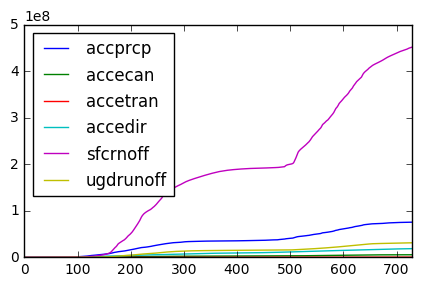

In [37]:
ferlin.plot()

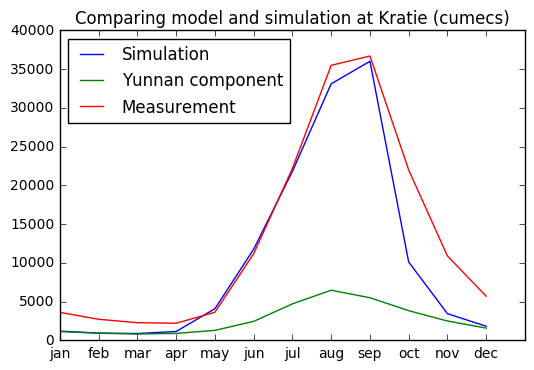

[5.16133667e+01 1.93155000e+01 6.06256452e+01 2.49220900e+02
 2.79562152e+03 9.31707287e+03 1.71007403e+04 2.66339854e+04
 3.05085960e+04 6.28279677e+03 9.44584500e+02 2.43617484e+02]
0     1150
1      930
2      830
3      910
4     1300
5     2460
6     4720
7     6480
8     5510
9     3840
10    2510
11    1590
Name: Chiang Saen, dtype: int64
0      1201.613367
1       949.315500
2       890.625645
3      1159.220900
4      4095.621516
5     11777.072867
6     21820.740258
7     33113.985355
8     36018.596000
9     10122.796774
10     3454.584500
11     1833.617484
Name: Chiang Saen, dtype: float64
7850.64918046595
MSE 0    -0.668063
1    -0.652265
2    -0.611081
3    -0.477828
4     0.125171
5     0.051524
6    -0.017084
7    -0.067212
8    -0.018567
9    -0.539873
10   -0.683066
11   -0.678876
dtype: float64


In [35]:
plt.rcParams['figure.figsize'] = 6,4
np.shape(test3)
month_name=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
plt.plot(test3[5,:]+baseflow['Chiang Saen'],label='Simulation') #2015
plt.plot(baseflow['Chiang Saen'],label='Yunnan component')
plt.plot(baseflow['Kratie'],label='Measurement')
plt.legend(loc='upper left')
plt.title('Comparing model and simulation at Kratie (cumecs)') #1960-2004
ax=plt.gca()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(month_name)
plt.show()
print(test3[5,:])
print(baseflow['Chiang Saen'])
print(test3[5,:]+baseflow['Chiang Saen'])
print(np.mean(test3[5,:]))
print('MSE',(test3[5,:]+baseflow['Chiang Saen']-baseflow['Kratie'])/baseflow['Kratie'])

Direct comparison of modelled river heights. Not recommended. Remember to change variable 'test3' to be based on depth instead of 'streamflow m3s'

In [28]:
def CalcNoahmpWatBudg(ldasoutDf_e,ldasoutDf_b,rtoutDf_e=None,rtoutDf_b=None,gwoutDf=None,sfcrt=False,soildeps=np.array([100,300,600,1000]),basarea=None):
    '''Calculates waterbudget for wrfhydro
    Adapted from function of same name @ https://rdrr.io/github/mccreigh/rwrfhydro/src/R/calculate_stats.R
    Converted to python by likkhian
    '''
    wbDf={}
    # LSM variables used for all cases
    wbDf['LSM_PRCP']=ldasoutDf_e['ACCPRCP']-ldasoutDf_b['ACCPRCP']
    wbDf['LSM_ECAN']=ldasoutDf_e['ACCECAN']-ldasoutDf_b['ACCECAN']
    wbDf['LSM_ETRAN']=ldasoutDf_e['ACCETRAN']-ldasoutDf_b['ACCETRAN']
    wbDf['LSM_EDIR']=ldasoutDf_e['ACCEDIR']-ldasoutDf_b['ACCEDIR']
    wbDf['LSM_DELSWE']=ldasoutDf_e['SNEQV']-ldasoutDf_b['SNEQV']
    wbDf['LSM_DELCANWAT']=(ldasoutDf_e['CANICE']+ldasoutDf_e['CANLIQ'])- \
        (ldasoutDf_e['CANICE']+ldasoutDf_e['CANLIQ'])
    # LSM variables that may not be used
    wbDf['LSM_SFCRNOFF']=ldasoutDf_e['SFCRNOFF']-ldasoutDf_b['SFCRNOFF']
    wbDf['LSM_UGDRNOFF']=ldasoutDf_e['UGDRNOFF']-ldasoutDf_b['UGDRNOFF']
    soilm=0.0
    for i in range(len(soildeps)):
        soilm+= soildeps[i]*(ldasoutDf_e['SOIL_M'][i]-ldasoutDf_b['SOIL_M'][i])
    wbDf['LSM_DELSOILM']=soilm
    # HYDRO surface/subsurface water fluxes
    if(rtoutDf_e):
        wbDf['HYD_QSTRMVOL']=rtoutDf_e['QSTRMVOLRT']-rtoutDf_b['QSTRMVOLRT']
        wbDf['HYD_DELSFCHEAD']=rtoutDf_e['SFCHEADSUBRT']-rtoutDf_b['SFCHEADSUBRT']
        wbDf['HYD_QBDRY']=rtoutDf_e['QBDRYRT']-rtoutDf_b['QBDRYRT']
    else:
        print('no routing output dataframe was provided. normally one would use LSM \
        surface runoff.')
        wbDf['HYD_QSTRMVOL']=None
        wbDf['HYD_DELSFCHEAD']=None
        wbDf['HYD_QBDRY']=None
    # HYDRO groundwater fluxes. Assumed not present
    if(gwoutDf is not None):
        if(basarea):
            print('gwout!')
            dt=(gwoutDf['POSIXct'].iloc[-1]-gwoutDf['POSIXct'].iloc[0]).total_seconds()
            wbDf['HYD_GWOUT']=np.nanmean(gwoutDf['q_cms'])*len(gwoutDf['basin'].unique())/(basarea*1000*1000)*1000*dt
            #have to figure out if i should sum up all basins first
        else:print('Error, no basarea provided')
    else:
        wbDf['HYD_GWOUT']=None
    # Overland routing check
    if(sfcrt):
        wbDf['WB_SFCRNOFF']=wbDf['HYD_QSTRMVOL']
    else:
        wbDf['WB_SFCRNOFF']=wbDf['LSM_SFCRNOFF']
    # groundwater routing check
    if(gwoutDf is not None):
        if(sfcrt):
            wbDf['WB_GWOUT']=wbDf['HYD_GWOUT']
        else:
            wbDf['WB_GWOUT']=wbDf['HYD_GWOUT']-wbDf['LSM_SFCRNOFF']
    else:
        wbDf['WB_GWOUT']=wbDf['LSM_UGDRNOFF']
    wbDf['WB_DELGWSTOR']=ldasoutDf_e['UGDRNOFF']-ldasoutDf_b['UGDRNOFF']-wbDf['WB_GWOUT']
    #Water budget error
    wbDf['ERROR']=wbDf['LSM_PRCP']-wbDf['LSM_ECAN']-wbDf['LSM_ETRAN']-wbDf['LSM_EDIR']-wbDf['WB_SFCRNOFF']- \
        (wbDf['HYD_QBDRY'] if wbDf['HYD_QBDRY'] else 0.0) - \
        wbDf['WB_GWOUT']-wbDf['LSM_DELSOILM']-wbDf['LSM_DELSWE']-wbDf['LSM_DELCANWAT'] - \
        (wbDf['HYD_DELSFCHEAD'] if wbDf['HYD_DELSFCHEAD'] else 0.0) - \
        (wbDf['WB_DELGWSTOR'] if wbDf['WB_DELGWSTOR'] else 0.0)
    wbDf['RUN_FRAC']=(wbDf['WB_SFCRNOFF']+(wbDf['HYD_QBDRY'] if wbDf['HYD_QBDRY'] else 0.0)+\
        wbDf['WB_GWOUT'])/wbDf['LSM_PRCP']
    wbDf['EVAP_FRAC']=(wbDf['LSM_ECAN']+wbDf['LSM_ETRAN']+wbDf['LSM_EDIR'])/wbDf['LSM_PRCP']
    wbDf['STOR_FRAC']=(wbDf['LSM_DELSOILM']+wbDf['LSM_DELSWE']+wbDf['LSM_DELCANWAT']+ \
        (wbDf['HYD_DELSFCHEAD'] if wbDf['HYD_DELSFCHEAD'] else 0.0)+ \
        (wbDf['WB_DELGWSTOR'] if wbDf['WB_DELGWSTOR'] else 0.0))/wbDf['LSM_PRCP']
    return wbDf

def apply_mask(file,variables,mask):
    '''Similar to ReadLdasoutAll from rwrfhydro
    @ https://github.com/NCAR/rwrfhydro/blob/master/R/read_modelout.R
    '''
    outdict={}
    for variable in variables:
        if(variable == 'SOIL_M'):
            outdict[variable]=np.empty([4])
            for i in range(0,4):
                inter=file[variable][0,:,i,:].data
                inter[inter<0]=0
                outdict[variable][i]=np.nanmean(inter*mask)
        else:
            inter=file[variable].data
            inter[inter<0]=0
            outdict[variable]=np.nanmean(inter*mask)
    return outdict

def ReadGwOut(pathOutfile,start_d=None,end_d=None):
    '''Reads WRF-Hydro groundwater output files and converts a dataframe
    with consistent date and data columns for use with other tools
    use GW_outflow.txt.
    Adapted from rwrfhydro @ https://github.com/NCAR/rwrfhydro/blob/master/R/read_modelout.R
    added ability to set start and end dates
    converted to python by likkhian
    '''
    df=pd.read_table(pathOutfile,names=["basin","timest","q_cms"],delim_whitespace=True)
    df['q_cms']=df['q_cms']#/(0.3048**3)
    df['POSIXct']=pd.to_datetime(df['timest'],format="%Y-%m-%d_%H:%M:%S")
    if(start_d or end_d):
        start=df['POSIXct'].iloc[0]
        end=df['POSIXct'].iloc[-1]
        if(start_d):
            start=pd.to_datetime(start_d)
        if(end_d):
            end=pd.to_datetime(end_d)
        mask = (df['POSIXct'] > start) & (df['POSIXct'] <= end)
        df=df.loc[mask]
        print(start,end)
    return df
    

In [29]:
msk_d02=np.load('../wrfhydro_output/basn_msk_d02.npy')

fulldom=xr.open_dataset('../wrfhydro_output/Fulldom_hiresD.nc')
msk_hydro=fulldom.basn_msk.data>0
msk_hydro=msk_hydro*1
msk_hydro=msk_hydro.astype(float)
msk_hydro[msk_hydro == 0] = np.nan
msk_hydro=np.flip(msk_hydro,axis=0)
basarea=np.nansum(msk_hydro)*0.9*0.9
print(basarea)
variables=['ACCPRCP','ACCECAN','ACCETRAN','ACCEDIR','SNEQV','CANICE','CANLIQ','SFCRNOFF',\
          'UGDRNOFF','SOIL_M']
variables_2=['QSTRMVOLRT','SFCHEADSUBRT','QBDRYRT']
gwoutDf=ReadGwOut('../wrfhydro_output/waterbalance_s101gw/GW_outflow.txt','2050-01-01','2051-12-31')
balance=CalcNoahmpWatBudg(apply_mask(xr.open_dataset('../wrfhydro_output/waterbalance_s101gw/2051123100.LDASOUT_DOMAIN2'),variables,msk_d02), \
                         apply_mask(xr.open_dataset('../wrfhydro_output/waterbalance_s101gw/2050010100.LDASOUT_DOMAIN2'),variables,msk_d02), \
                         apply_mask(xr.open_dataset('../wrfhydro_output/waterbalance_s101gw/205112310000.RTOUT_DOMAIN2'),variables_2,msk_hydro), \
                         apply_mask(xr.open_dataset('../wrfhydro_output/waterbalance_s101gw/205001010000.RTOUT_DOMAIN2'),variables_2,msk_hydro), \
                         gwoutDf,sfcrt=True,basarea=basarea)
balance

525519.09
2050-01-01 00:00:00 2051-12-31 00:00:00
gwout!


{'ERROR': 32.67768550813025,
 'EVAP_FRAC': 0.35338620798354636,
 'HYD_DELSFCHEAD': 0.05555935153716881,
 'HYD_GWOUT': 4119.597960503849,
 'HYD_QBDRY': 0.0,
 'HYD_QSTRMVOL': 620.6855867877495,
 'LSM_DELCANWAT': 0.0,
 'LSM_DELSOILM': 148.33646126339283,
 'LSM_DELSWE': 1.641400419974098e-06,
 'LSM_ECAN': 323.6637661930375,
 'LSM_EDIR': 1008.7645461012429,
 'LSM_ETRAN': 41.35501383758256,
 'LSM_PRCP': 3887.484273850965,
 'LSM_SFCRNOFF': 6266.679685014785,
 'LSM_UGDRNOFF': 1711.9456531668916,
 'RUN_FRAC': 1.219370475445254,
 'STOR_FRAC': -0.5811625529336457,
 'WB_DELGWSTOR': -2407.6523073369576,
 'WB_GWOUT': 4119.597960503849,
 'WB_SFCRNOFF': 620.6855867877495}

In [30]:
balance2=CalcNoahmpWatBudg(apply_mask(xr.open_dataset('../wrfhydro_output/waterbalance_s101/2054123100.LDASOUT_DOMAIN2'),variables,msk_d02), \
                         apply_mask(xr.open_dataset('../wrfhydro_output/waterbalance_s101/2051010100.LDASOUT_DOMAIN2'),variables,msk_d02), \
                         apply_mask(xr.open_dataset('../wrfhydro_output/waterbalance_s101/205412310000.RTOUT_DOMAIN2'),variables_2,msk_hydro), \
                         apply_mask(xr.open_dataset('../wrfhydro_output/waterbalance_s101/205101010000.RTOUT_DOMAIN2'),variables_2,msk_hydro), \
                         sfcrt=True)
balance2


{'ERROR': 138.28808099732615,
 'EVAP_FRAC': 0.30629842663045564,
 'HYD_DELSFCHEAD': 0.0052646910970924835,
 'HYD_GWOUT': None,
 'HYD_QBDRY': 0.0,
 'HYD_QSTRMVOL': 2136.037043345477,
 'LSM_DELCANWAT': 0.0,
 'LSM_DELSOILM': 30.3425599502486,
 'LSM_DELSWE': 0.0,
 'LSM_ECAN': 750.8203255996648,
 'LSM_EDIR': 2316.3050420901245,
 'LSM_ETRAN': 56.85479297888163,
 'LSM_PRCP': 10199.138777939937,
 'LSM_SFCRNOFF': 20588.766077499782,
 'LSM_UGDRNOFF': 4770.485668287118,
 'RUN_FRAC': 0.6771672453924195,
 'STOR_FRAC': 0.0029755281599840597,
 'WB_DELGWSTOR': 0.0,
 'WB_GWOUT': 4770.485668287118,
 'WB_SFCRNOFF': 2136.037043345477}

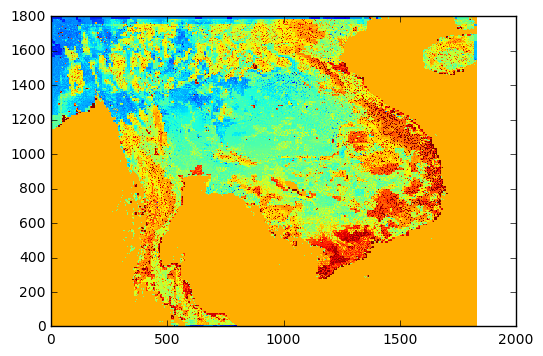

/Users/likkhian/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


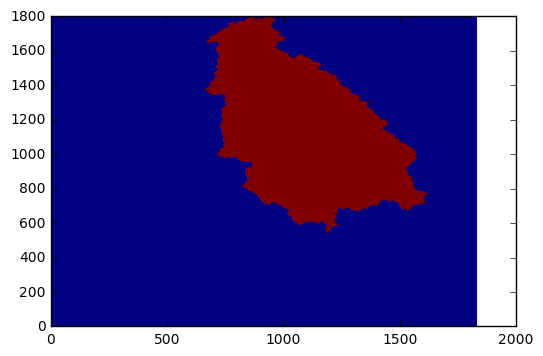

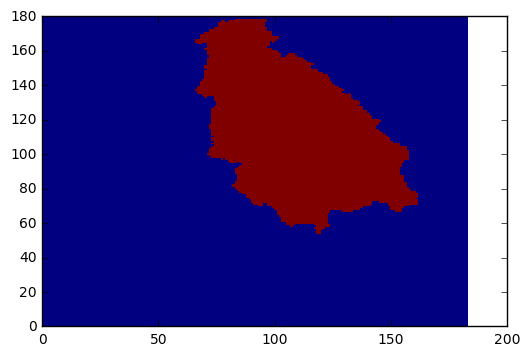

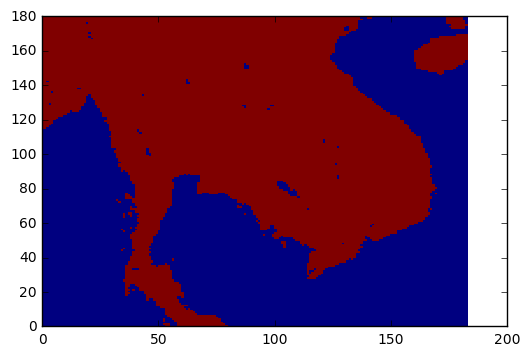

<xarray.Dataset>
Dimensions:                  (depth: 4, time: 1, x: 1830, y: 1800)
Coordinates:
  * time                     (time) datetime64[ns] 2054-12-31
  * x                        (x) float64 -8.365e+05 -8.356e+05 -8.347e+05 ...
  * y                        (y) float64 6.803e+05 6.812e+05 6.821e+05 ...
  * depth                    (depth) float32 -0.1 -0.4 -1.0 -2.0
Data variables:
    LATITUDE                 (y, x) float32 6.288286 6.288286 6.288286 ...
    LONGITUDE                (y, x) float32 95.29047 95.298805 95.30714 ...
    SOIL_M 1                 (time, y, x) float32 0.339 0.339 0.339 0.339 ...
    SOIL_M 2                 (time, y, x) float32 0.339 0.339 0.339 0.339 ...
    SOIL_M 3                 (time, y, x) float32 0.339 0.339 0.339 0.339 ...
    SOIL_M 4                 (time, y, x) float64 0.339 0.339 0.339 0.339 ...
    ZWATTABLRT               (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    QSTRMVOLRT               (time, y, x) float64 0.0 0.0 0.0 0.0 

In [34]:
aa=xr.open_dataset('../wrfhydro_output/waterbalance_s101/205412310000.RTOUT_DOMAIN2')
bb=xr.open_dataset('../wrfhydro_output/waterbalance_s101/2054123100.LDASOUT_DOMAIN2')
plt.figure(1)
plt.pcolormesh(aa['SOIL_M 1'].data[0,:,:])
plt.colorbar
plt.figure(2)
plt.pcolormesh((msk_hydro),vmin=0,vmax=1)
plt.figure(3)
plt.pcolormesh(msk_d02,vmin=0,vmax=1)
plt.figure(4)
plt.pcolormesh(bb['ACCPRCP'][0,:,:])
plt.show()
print(aa)